In [1]:
%matplotlib inline

from datetime import datetime
tic = datetime.now()

import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

In [2]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
HMAX = 1000 #Maximum harvested energy
DMAX = 500
N_ACTIONS = 10
DMIN = DMAX/N_ACTIONS
AMIN = 1 
AMAX = N_ACTIONS
DSCALE = DMAX/N_ACTIONS #scale to convert action value to actual power consumption
NMAX = DMAX

BMIN = 0.0
BMAX = 9250.0
BOPT = 0.5 * BMAX
BINIT = 0.5 * BMAX

In [4]:
location = 'tokyo'
year = 2018

In [5]:
THIS_DIR = getcwd()
SDATA_DIR = abspath(join(THIS_DIR, '../' 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))

sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'

#skiprows=4 to remove unnecessary title texts
#usecols=4 to read only the Global Solar Radiation (GSR) values
solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])

#convert dataframe to numpy array
solar_radiation = solar_radiation.values

#convert missing data in CSV files to zero
solar_radiation[np.isnan(solar_radiation)] = 0

#reshape solar_radiation into no_of_daysx24 array
solar_radiation = solar_radiation.reshape(-1,24)

#GSR values (in MJ/sq.mts per hour) need to be expressed in mW
# Conversion is accomplished by 
# solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
# the factor of 2 in the end is assuming two solar cells
senergy = 2*solar_radiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

In [6]:
TIME_STEPS = senergy.shape[1]
NO_OF_DAYS = senergy.shape[0]

In [7]:
senergy = np.clip(senergy,0,HMAX)

In [8]:
def solve(henergy, b_INIT):
    SLOTS = len(henergy)

    optimization_flag = None #0 = lowest duty cycle; 1 = LP solution; 2 = highest duty cycle;

    #the epochs in a window of TIME_STEPS numbers of slots
    epoch = ['epoch_%d' %i for i in range(1, TIME_STEPS + 1, 1)]

    #Create dictionary of harvested energy
    henergy_dict = dict(zip(epoch, henergy))


    if sum(henergy) < AMIN*DSCALE*TIME_STEPS:
        #print("Always on lowest duty cycle")
        optimization_flag = 0
    elif sum(henergy) > AMAX*DSCALE*TIME_STEPS:
        #print("Always on highest duty cycle")
        optimization_flag = 2
    else:
        #Define the LP problem as "ENO" as type Minimization
        model = pulp.LpProblem('ENO', pulp.LpMinimize)


        # create a dictionary of pulp LpVariables with keys corresponding to values in the list epoch
        action_dict = pulp.LpVariable.dicts('action', epoch , 
                                           lowBound=AMIN, upBound=AMAX, 
                                           cat=pulp.LpInteger)


        total_consumed_energy = pulp.lpSum([action_dict[key] for key in epoch]) * DSCALE
        deviation = (BOPT - (b_INIT + sum(henergy) - total_consumed_energy))

        #Objective function is to minimize the deviation from optimal battery level
        #Create a variable t such that |deviation|<=t
        #We tolerate a deviation of maximum 50 mWh
        # -t <= deviation <= t
        t = pulp.LpVariable('t', lowBound=50, cat='Continuous')
        model += t

        #Constraints A
        model += deviation <= t
        model += deviation >= -t

        #Constraints B
        #Create a dummy list of lists with entries [[epoch_1], [epoch_1, epoch_2], .... ]
        dummy = [epoch[0:i] for i in range(1,len(epoch)+1)]

        #dictionary of cumulative action variables [[a1], [a1 + a2],....]
        a_var_cum = {}

        #dictionary of cumulative harvested energy constants [[h1], [h1 + h2],....]
        henergy_cum = {} 

        for i in range(0 , len(epoch)):
            a_var_cum[epoch[i]] = pulp.lpSum([action_dict[key]*DSCALE for key in dummy[i]])
            henergy_cum[epoch[i]] = sum([henergy_dict[key] for key in dummy[i]])
            #henergy_cum = dict(zip(epoch, np.add.accumulate(henergy)))


        for key in epoch:
            model += b_INIT + henergy_cum[key] - a_var_cum[key] <= BMAX
            model += b_INIT + henergy_cum[key] - a_var_cum[key] >= BMIN

        #Solve the model
        optimization_flag = model.solve()
#         print(pulp.LpStatus[model.status], optimization_flag)

    #Create list of optimized actions
    opt_act = {}
    if optimization_flag <= 0:
        a_val = [AMIN]*TIME_STEPS
    elif optimization_flag == 1:
        for var in epoch:
            opt_act[var] = action_dict[var].varValue
            a_val = list(opt_act.values())
    elif optimization_flag == 2:
        a_val = [AMAX]*TIME_STEPS

    return a_val

In [9]:
n_val_rec = np.zeros_like(senergy)
a_val_rec = np.zeros_like(senergy)
batt_val_rec = np.zeros_like(senergy)
previous_batt = BINIT
for day in np.arange(0,NO_OF_DAYS):
    a_val_rec[day] = np.array(solve(senergy[day],previous_batt))
    n_val_rec[day] = a_val_rec[day]*DSCALE
    for hour in np.arange(0, TIME_STEPS):
        batt_val_rec[day][hour] = previous_batt + senergy[day][hour] - n_val_rec[day][hour]
        batt_val_rec[day][hour] = np.clip(batt_val_rec[day][hour] ,0,BMAX)
        previous_batt = batt_val_rec[day][hour]

In [10]:
np.save('lp_action_TOKYO_2018',a_val_rec)
np.save('lp_battery_TOKYO_2018',batt_val_rec)

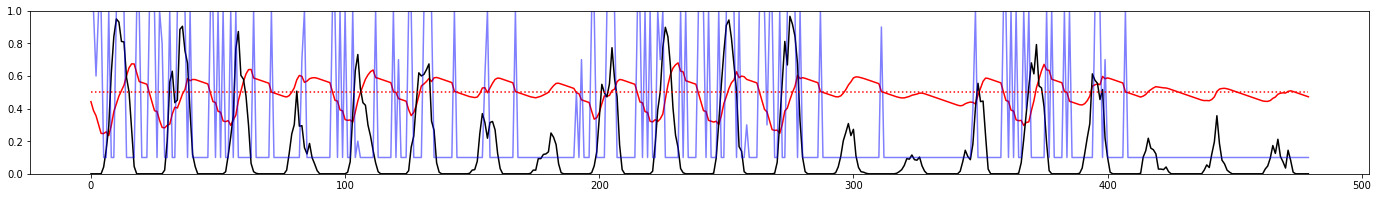

In [11]:
#plot the battery, henergy and node energy consumption profile for day = (0,364)
day_start = 250
day_end = 270

fig = plt.figure(figsize=(24,3))
ax = fig.add_subplot(111)
ax.plot((batt_val_rec[day_start:day_end]/BMAX).flatten(),'r')
ax.plot((senergy[day_start:day_end]/HMAX).flatten(),'k-')
ax.plot((n_val_rec[day_start:day_end]/DMAX).flatten(),'b',alpha=0.5)
ax.plot([BOPT/BMAX]*np.ones_like(batt_val_rec[day_start:day_end]).flatten(),'r:')
ax.set_ylim([0,1])


plt.show()


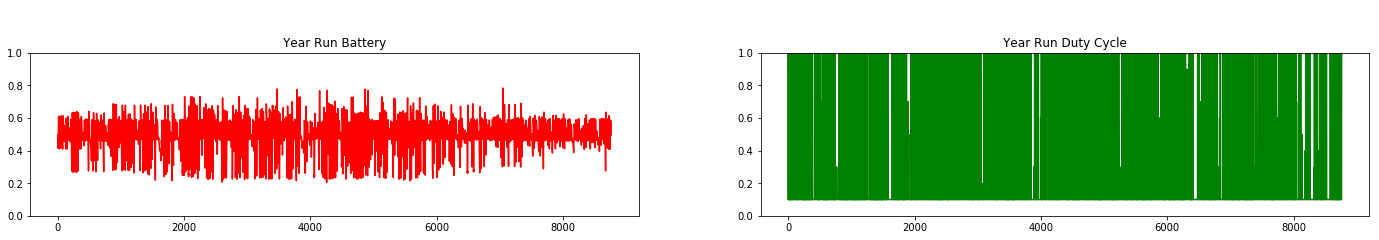

In [12]:
fig = plt.figure(figsize=(24,3))
ax = fig.add_subplot(121)
ax.plot(batt_val_rec.flatten()/BMAX,'r')
ax.set_title("\n\nYear Run Battery")
ax.set_ylim([0,1])

ax1 = fig.add_subplot(122)
ax1.plot(n_val_rec.flatten()/DMAX,'g')
ax1.set_title("\n\nYear Run Duty Cycle")
ax1.set_ylim([0,1])

plt.show()